What is the filename you want to look at: assess2_data.json


(0.45, 1.0)

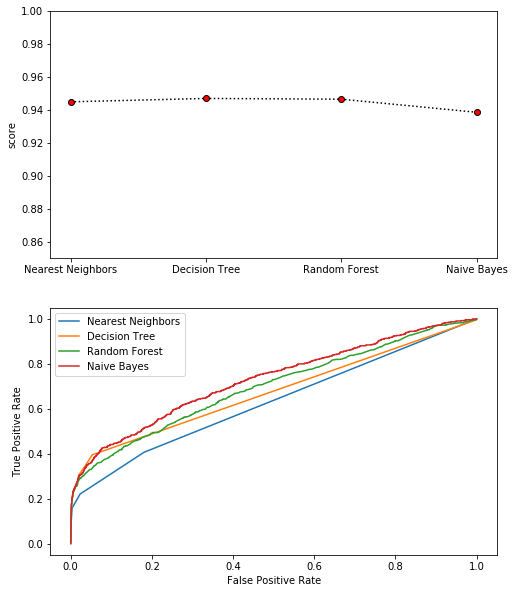

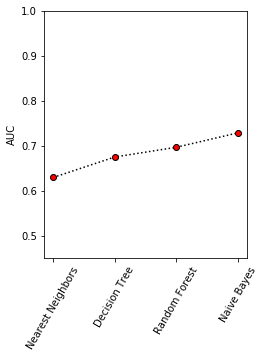

In [25]:
import json
import pandas as pd
import sqlite3
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

filename = input("What is the filename you want to look at: ")

with open(filename) as json_data:
    data = json.load(json_data,)  

df = pd.DataFrame(data)
#Removes the lines that we found with missing data in part 2

df2 = df.drop([27085, 16436, 28318], axis=0)

#Drops columns that we do not want to use
df3 = df2.drop(['NAME', 'FISTDATE', 'LASTDATE', 'PEPSTRFL'], axis=1)
df3['RFA_2A'] = df3['RFA_2A'].map({'D': 0, 'E': 1, 'F': 2, "G": 3})

#For the purposes of part10 we do not need to alphabetize or know the counts so we can skip to part10
target = df3["TARGET_B"]
#drop TARGET_B so that we have just the feature vectors. 
df4 = df3.drop(["TARGET_B"], axis=1)
#We can now creating training and test data on the feature vectors (df4) and target
X_train, X_test, y_train, y_test = train_test_split(df4, target)
#We can now create the names of the 4 classifiers we want to look at. 
names = ["Nearest Neighbors", 
         "Decision Tree", "Random Forest", 
         "Naive Bayes"]
#Call all the classifiers
classifiers = [
    KNeighborsClassifier(4),
    DecisionTreeClassifier(max_depth=4),
    RandomForestClassifier(max_depth=4, n_estimators=10, max_features=1),
    GaussianNB(),
   ]
#Calculate the fit, the model score and the prediction probability
scores2 = []
pred = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    scores2.append(clf.score(X_test, y_test))
    pred.append(clf.predict_proba(X_test)) 

#first we will plot the accuracy score. This is figure 1.
plt.ion()
fig = plt.figure(figsize=[8,10])
ax = fig.add_subplot(211)
ax.plot(scores2, ':o', c='k', mfc='r')
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names)
ax.set_ylabel('score')
ax.set_ylim(.85, 1.)

#The accuracy scores change based on which values are added to the training set or the test set. They are all very close
#making it difficult to pick on this metric alone. 

pred2 = np.array(pred)
pred2 = np.transpose(pred2)
fpr=[]
tpr=[]
#This for loop allows us to fill in the fpr and tpr for each range. Giving us the second plot of fpr vs. tpr
for i in range(len(names)):
    fprclf, tprclf, thresholds = roc_curve(y_test, pred2[1,:,i], pos_label=1)
    fpr.append(fprclf)
    tpr.append(tprclf)

ax2 = fig.add_subplot(212)
ax2.set_ylabel("True Positive Rate")
ax2.set_xlabel("False Positive Rate")

roc_score = []
#The following for loop creates the ROC graph and provides the ROC_Score == the Area under the curve
for i in range (0,len(fpr)):
    ax2.plot(fpr[i], tpr[i], label=names[i])
    ax2.legend(names)
    roc_score.append(roc_auc_score(y_test, pred2[1,:,i]))
#The final plot shows the AUC for each option.    
fig = plt.figure(figsize=[8,10])
ax3 = fig.add_subplot(222)
ax3.plot(roc_score, ':o', c='k', mfc='r')

ax3.set_xticks(range(len(names)))
ax3.set_xticklabels(names)
ax3.set_ylabel('AUC')
ax3.xaxis.set_tick_params(rotation=60)
ax3.set_ylim(.45, 1.)
